In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer
from torchvision.models import resnet50
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import torch.optim as optim

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

class ResNetFeatureExtractor(nn.Module):
    def __init__(self, output_dim=768):
        super().__init__()

        resnet = resnet50(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])
        self.pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, output_dim)

    def forward(self, x):
        x = self.backbone(x)
        x = self.pooling(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

class CrossAttention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)
        self.scale = dim ** -0.5

    def forward(self, x, y):
        q = self.query(x)
        k = self.key(y)
        v = self.value(y)

        attention = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attention = torch.softmax(attention, dim=-1)
        out = torch.matmul(attention, v)
        return out

class VQAModel(nn.Module):
    def __init__(self, num_classes=2, hidden_dim=768):
        super().__init__()

        self.resnet_features = ResNetFeatureExtractor(output_dim=hidden_dim)

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.bert_projection = nn.Linear(768, hidden_dim)

        self.fusion = CrossAttention(hidden_dim)

        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, image, question_ids, attention_mask):
        # process image
        image_features = self.resnet_features(image)

        # process question
        question_output = self.bert(question_ids, attention_mask=attention_mask)
        question_features = self.bert_projection(question_output.last_hidden_state)

        # fusion through cross-attention
        fused_features = self.fusion(question_features, image_features.unsqueeze(1))

        # attention mechanism
        attention_weights = self.attention(fused_features)
        attention_weights = torch.softmax(attention_weights, dim=1)
        attended_features = (fused_features * attention_weights).sum(dim=1)

        # generate output prediction
        logits = self.classifier(attended_features)
        return logits

def preprocess_image():
    return Compose([
        Resize((224, 224)),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def preprocess_question(question: str, max_length: int = 64):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    tokens = tokenizer(
        question,
        padding='max_length',
        max_length=max_length,
        truncation=True,
        return_tensors='pt'
    )
    return tokens

class ShapeGenerator:
    def __init__(self, img_size=(224,224), noise=0):
        self.img_size = img_size
        self.shapes = ['circle', 'square', 'triangle']
        self.colors = {
            'red': (255, 0, 0),
            'blue': (0, 0, 255),
            'green': (0, 255, 0)
        }
        self.positions = ['above', 'below', 'left of', 'right of']
        self.shape_size = 40
        self.noise = noise

    def __shape__(self, draw, shape, color, pos):
        if shape == 'circle':
            draw.ellipse([pos[0]-self.shape_size//2,
                         pos[1]-self.shape_size//2,
                         pos[0]+self.shape_size//2,
                         pos[1]+self.shape_size//2],
                         fill=self.colors[color])
        elif shape == 'square':
            draw.rectangle([pos[0]-self.shape_size//2,
                          pos[1]-self.shape_size//2,
                          pos[0]+self.shape_size//2,
                          pos[1]+self.shape_size//2],
                          fill=self.colors[color])
        elif shape == 'triangle':
            points = [
                (pos[0], pos[1]-self.shape_size//2),
                (pos[0]-self.shape_size//2, pos[1]+self.shape_size//2),
                (pos[0]+self.shape_size//2, pos[1]+self.shape_size//2)
            ]
            draw.polygon(points, fill=self.colors[color])

    def __spatial__(self, pos1, pos2, rel):
        if rel == 'above':
            return pos1[1] < pos2[1]
        elif rel == 'below':
            return pos1[1] > pos2[1]
        elif rel == 'left of':
            return pos1[0] < pos2[0]
        elif rel == 'right of':
            return pos1[0] > pos2[0]

    def generate_sample(self):
        img = Image.new('RGB', self.img_size, 'white')
        draw = ImageDraw.Draw(img)

        shape1 = np.random.choice(self.shapes)
        shape2 = np.random.choice(self.shapes)
        color1 = np.random.choice(list(self.colors.keys()))
        color2 = np.random.choice(list(self.colors.keys()))
        position = np.random.choice(self.positions)

        margin = self.shape_size
        if position in ['above', 'below']:
            x1 = np.random.randint(margin, self.img_size[0]-margin)
            x2 = np.random.randint(margin, self.img_size[0]-margin)
            if position == 'above':
                y1 = self.img_size[1]//3
                y2 = 2*self.img_size[1]//3
            else:
                y1 = 2*self.img_size[1]//3
                y2 = self.img_size[1]//3
        else:  # left or right
            y1 = np.random.randint(margin, self.img_size[1]-margin)
            y2 = np.random.randint(margin, self.img_size[1]-margin)
            if position == 'left of':
                x1 = self.img_size[0]//3
                x2 = 2*self.img_size[0]//3
            else:
                x1 = 2*self.img_size[0]//3
                x2 = self.img_size[0]//3

        self.__shape__(draw, shape1, color1, (x1, y1))
        self.__shape__(draw, shape2, color2, (x2, y2))

        question = f"Is there a {color1} {shape1} {position} a {color2} {shape2}?"
        answer = 'yes' if self.__spatial__((x1, y1), (x2, y2), position) else 'no'

        return img, question, answer

class ShapesDataset(Dataset):
    def __init__(self, num_samples=1000, transform=None, split='train', noise=(0,0,0)):
        self.transform = transform
        self.generator = ShapeGenerator(noise=noise)
        self.n = num_samples
        self.data = []
        self.noise_indices = []
        self.tv_noise = noise[0]
        self.shape_noise = noise[1]
        self.color_noise = noise[2]

        for i in tqdm(range(self.n)):
            img, ques, ans = self.generator.generate_sample()

            if np.random.rand() < self.tv_noise:
                img = self.__tv_noise__(img)
                self.noise_indices.append(i)

            if np.random.rand() < self.shape_noise:
                ques = self.__shape_noise__(ques)
                ans = 'no'
                self.noise_indices.append(i)
            if np.random.rand() < self.color_noise:
                ques = self.__color_noise__(ques)
                ans = 'no'
                self.noise_indices.append(i)

            self.data.append((img, ques, ans))

        self.ans2idx = {'yes':0, 'no':1}

    def __tv_noise__(self, img):
        np_img = np.array(img)
        noise = np.random.randint(0, 64, (np_img.shape[0], np_img.shape[1], np_img.shape[2]), dtype='uint8')
        np_img = np.clip(np_img + noise, 0, 255)
        return Image.fromarray(np_img)

    def __shape_noise__(self, ques):
        shapes = ['circle', 'square', 'triangle']
        current_shape = [shape for shape in shapes if shape in ques][0]
        new_shape = np.random.choice([s for s in shapes if s != current_shape])
        return ques.replace(current_shape, new_shape)

    def __color_noise__(self, ques):
        colors = ['red', 'blue', 'green']
        current_color = [color for color in colors if color in ques][0]
        new_color = np.random.choice([c for c in colors if c != current_color])
        return ques.replace(current_color, new_color)

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        img, ques, ans = self.data[idx]

        if self.transform:
            img = self.transform(img)

        return {
            'image' : img,
            'question' : ques,
            'answer' : torch.tensor(self.ans2idx[ans], dtype=torch.long)
        }

    def visualise_sample(self, idx):
        img, ques, ans = self.data[idx]
        plt.figure(figsize=(10,5))
        plt.imshow(img)
        plt.title(f"Q : {ques}\nA: {ans}")
        plt.axis('off')
        plt.show()

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(dataloader, desc='Training'):
        images = batch['image'].to(device)
        questions = batch['question']
        answers = batch['answer'].to(device)

        # process questions through BERT tokenizer
        question_tokens = tokenizer(questions, padding=True, truncation=True,
                                  return_tensors='pt').to(device)

        optimizer.zero_grad()
        outputs = model(images, question_tokens.input_ids,
                       question_tokens.attention_mask)

        loss = criterion(outputs, answers)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += answers.size(0)
        correct += predicted.eq(answers).sum().item()

    return total_loss / len(dataloader), 100. * correct / total

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Validating'):
            images = batch['image'].to(device)
            questions = batch['question']
            answers = batch['answer'].to(device)

            question_tokens = tokenizer(questions, padding=True, truncation=True,
                                      return_tensors='pt').to(device)

            outputs = model(images, question_tokens.input_ids,
                          question_tokens.attention_mask)
            loss = criterion(outputs, answers)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += answers.size(0)
            correct += predicted.eq(answers).sum().item()

    return total_loss / len(dataloader), 100. * correct / total

# define the image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])


# initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if __name__ == '__main__':
    train_dataset = ShapesDataset(num_samples=1000, transform=transform, split='train', noise=(0.1,0.1,0.1))
    test_dataset = ShapesDataset(num_samples=200, transform=transform, split='test', noise=(0.1,0.1,0.1))

    # dataloaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    # initialize model and training components
    model = VQAModel(num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # training loop with validation
    best_acc = 0
    test_accs = []
    test_losses = []
    train_accs = []
    train_losses = []
    for epoch in range(10):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion,
                                            optimizer, device)
        test_loss, test_acc = validate(model, test_loader, criterion, device)

        test_accs.append(test_acc)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        print(f'Epoch {epoch+1}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), 'best_model.pth')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 200/200 [00:00<00:00, 1309.89it/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.D

Epoch 1:
Train Loss: 0.5306, Train Acc: 79.10%
Test Loss: 0.5273, Test Acc: 78.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.59it/s]


Epoch 2:
Train Loss: 0.5144, Train Acc: 79.50%
Test Loss: 0.5198, Test Acc: 78.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.77it/s]


Epoch 3:
Train Loss: 0.5061, Train Acc: 79.50%
Test Loss: 0.5290, Test Acc: 78.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]


Epoch 4:
Train Loss: 0.4788, Train Acc: 79.50%
Test Loss: 0.6474, Test Acc: 78.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.50it/s]


Epoch 5:
Train Loss: 0.4652, Train Acc: 79.50%
Test Loss: 0.5706, Test Acc: 78.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.44it/s]


Epoch 6:
Train Loss: 0.4512, Train Acc: 79.70%
Test Loss: 0.5661, Test Acc: 78.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]


Epoch 7:
Train Loss: 0.4412, Train Acc: 79.50%
Test Loss: 0.6224, Test Acc: 78.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.76it/s]


Epoch 8:
Train Loss: 0.4111, Train Acc: 79.40%
Test Loss: 0.6070, Test Acc: 78.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]


Epoch 9:
Train Loss: 0.4046, Train Acc: 81.80%
Test Loss: 0.5784, Test Acc: 67.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.13it/s]

Epoch 10:
Train Loss: 0.3350, Train Acc: 86.50%
Test Loss: 1.3075, Test Acc: 77.00%


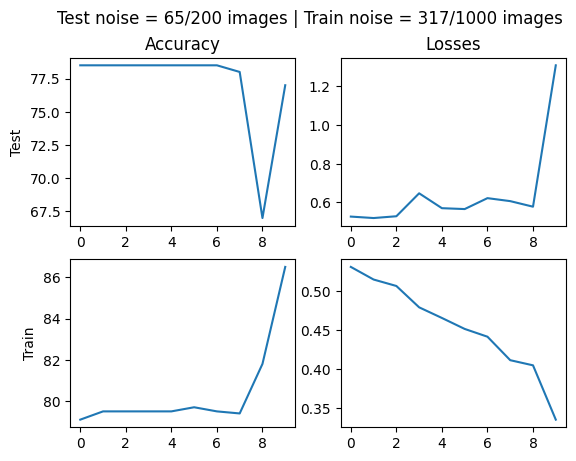

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2)
axes[0][0].plot(test_accs)
axes[0][0].set_title('Accuracy')
axes[0][0].set_ylabel('Test')
axes[0][1].plot(test_losses)
axes[0][1].set_title('Losses')
axes[1][0].plot(train_accs, label='Train Accuracy')
axes[1][0].set_ylabel('Train')
axes[1][1].plot(train_losses, label='Train Loss')
fig.suptitle(f"Test noise = {len(test_dataset.noise_indices)}/200 images | Train noise = {len(train_dataset.noise_indices)}/1000 images")
plt.show()

In [ ]:
noises = [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75]
best_acc_tv = []
def main():
  for n in noises:
    train_dataset = ShapesDataset(num_samples=1000, transform=transform, split='train', noise=(n,0.1,0.1))
    test_dataset = ShapesDataset(num_samples=200, transform=transform, split='test', noise=(n,0.1,0.1))

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    model = VQAModel(num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    best_acc_test = 0
    best_acc = 0
    for epoch in range(5):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion,
                                            optimizer, device)
        test_loss, test_acc = validate(model, test_loader, criterion, device)

        print(f'Epoch {epoch+1}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {test_loss:.4f}, Val Acc: {test_acc:.2f}%')

        if test_acc > best_acc_test:
            best_acc_test = test_acc

        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), 'best_tv_model_by_noise.pth')

    best_acc_tv.append(best_acc_test)


if __name__ == '__main__':
  main()

100%|██████████| 200/200 [00:00<00:00, 5131.21it/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Validating: 100%|██████████| 7/7 [00:01<00:00,  4.42it/s]


Epoch 1:
Train Loss: 0.5129, Train Acc: 81.00%
Val Loss: 0.5667, Val Acc: 79.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.08it/s]


Epoch 2:
Train Loss: 0.4822, Train Acc: 81.10%
Val Loss: 0.5578, Val Acc: 79.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.38it/s]


Epoch 3:
Train Loss: 0.4840, Train Acc: 81.10%
Val Loss: 0.5856, Val Acc: 79.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.40it/s]


Epoch 4:
Train Loss: 0.4702, Train Acc: 81.10%
Val Loss: 0.6595, Val Acc: 79.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.61it/s]


Epoch 5:
Train Loss: 0.4439, Train Acc: 81.10%
Val Loss: 0.6117, Val Acc: 79.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.43it/s]


Epoch 1:
Train Loss: 0.5317, Train Acc: 77.70%
Val Loss: 0.5004, Val Acc: 79.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.25it/s]


Epoch 2:
Train Loss: 0.4939, Train Acc: 79.30%
Val Loss: 0.5034, Val Acc: 79.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.38it/s]


Epoch 3:
Train Loss: 0.4944, Train Acc: 79.30%
Val Loss: 0.4952, Val Acc: 79.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.52it/s]


Epoch 4:
Train Loss: 0.4892, Train Acc: 79.30%
Val Loss: 0.6159, Val Acc: 79.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.93it/s]


Epoch 5:
Train Loss: 0.4450, Train Acc: 79.30%
Val Loss: 0.6604, Val Acc: 79.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.18it/s]


Epoch 1:
Train Loss: 0.5461, Train Acc: 78.20%
Val Loss: 0.5323, Val Acc: 80.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.26it/s]


Epoch 2:
Train Loss: 0.5150, Train Acc: 78.30%
Val Loss: 0.5135, Val Acc: 80.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.17it/s]


Epoch 3:
Train Loss: 0.5249, Train Acc: 78.30%
Val Loss: 0.5442, Val Acc: 80.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.89it/s]


Epoch 4:
Train Loss: 0.5046, Train Acc: 78.30%
Val Loss: 0.5559, Val Acc: 80.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.31it/s]


Epoch 5:
Train Loss: 0.4977, Train Acc: 78.30%
Val Loss: 0.5849, Val Acc: 80.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.18it/s]


Epoch 1:
Train Loss: 0.5047, Train Acc: 79.90%
Val Loss: 0.5128, Val Acc: 76.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.66it/s]


Epoch 2:
Train Loss: 0.4873, Train Acc: 81.40%
Val Loss: 0.5201, Val Acc: 76.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.86it/s]


Epoch 3:
Train Loss: 0.4730, Train Acc: 81.40%
Val Loss: 0.5674, Val Acc: 76.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.34it/s]


Epoch 4:
Train Loss: 0.4850, Train Acc: 81.40%
Val Loss: 0.5338, Val Acc: 76.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.33it/s]


Epoch 5:
Train Loss: 0.4657, Train Acc: 81.40%
Val Loss: 0.7036, Val Acc: 76.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.27it/s]


Epoch 1:
Train Loss: 0.5240, Train Acc: 80.10%
Val Loss: 0.4187, Val Acc: 85.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.29it/s]


Epoch 2:
Train Loss: 0.5034, Train Acc: 80.10%
Val Loss: 0.4636, Val Acc: 85.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.21it/s]


Epoch 3:
Train Loss: 0.4669, Train Acc: 80.10%
Val Loss: 0.6673, Val Acc: 85.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.23it/s]


Epoch 4:
Train Loss: 0.4113, Train Acc: 83.00%
Val Loss: 0.6900, Val Acc: 83.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.28it/s]


Epoch 5:
Train Loss: 0.4216, Train Acc: 83.20%
Val Loss: 0.7267, Val Acc: 64.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.16it/s]


Epoch 1:
Train Loss: 0.4722, Train Acc: 81.70%
Val Loss: 0.4973, Val Acc: 82.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.24it/s]


Epoch 2:
Train Loss: 0.4070, Train Acc: 83.90%
Val Loss: 0.7051, Val Acc: 82.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.13it/s]


Epoch 3:
Train Loss: 0.3561, Train Acc: 85.60%
Val Loss: 0.7424, Val Acc: 60.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.03it/s]


Epoch 4:
Train Loss: 0.3083, Train Acc: 86.70%
Val Loss: 1.3861, Val Acc: 82.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.02it/s]


Epoch 5:
Train Loss: 0.3275, Train Acc: 86.80%
Val Loss: 1.5495, Val Acc: 82.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.25it/s]


Epoch 1:
Train Loss: 0.5041, Train Acc: 80.10%
Val Loss: 0.5638, Val Acc: 79.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.19it/s]


Epoch 2:
Train Loss: 0.4492, Train Acc: 80.70%
Val Loss: 0.9324, Val Acc: 79.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.32it/s]


Epoch 3:
Train Loss: 0.3676, Train Acc: 85.90%
Val Loss: 1.4436, Val Acc: 79.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.05it/s]


Epoch 4:
Train Loss: 0.3695, Train Acc: 85.90%
Val Loss: 1.0302, Val Acc: 79.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.27it/s]


Epoch 5:
Train Loss: 0.3036, Train Acc: 87.20%
Val Loss: 0.6417, Val Acc: 77.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.22it/s]


Epoch 1:
Train Loss: 0.5081, Train Acc: 81.00%
Val Loss: 0.5148, Val Acc: 80.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.94it/s]


Epoch 2:
Train Loss: 0.4464, Train Acc: 81.70%
Val Loss: 0.6806, Val Acc: 80.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.14it/s]


Epoch 3:
Train Loss: 0.3359, Train Acc: 86.90%
Val Loss: 1.2457, Val Acc: 80.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.24it/s]


Epoch 4:
Train Loss: 0.3131, Train Acc: 86.90%
Val Loss: 0.5871, Val Acc: 79.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.26it/s]


Epoch 5:
Train Loss: 0.2845, Train Acc: 87.30%
Val Loss: 0.9270, Val Acc: 65.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.20it/s]


Epoch 1:
Train Loss: 0.5273, Train Acc: 78.50%
Val Loss: 0.4854, Val Acc: 82.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.04it/s]


Epoch 2:
Train Loss: 0.4085, Train Acc: 81.70%
Val Loss: 0.9157, Val Acc: 82.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.04it/s]


Epoch 3:
Train Loss: 0.3165, Train Acc: 88.60%
Val Loss: 1.4987, Val Acc: 52.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.96it/s]


Epoch 4:
Train Loss: 0.2701, Train Acc: 89.50%
Val Loss: 0.7048, Val Acc: 81.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.08it/s]


Epoch 5:
Train Loss: 0.2401, Train Acc: 90.50%
Val Loss: 0.9680, Val Acc: 82.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.83it/s]


Epoch 1:
Train Loss: 0.5167, Train Acc: 79.70%
Val Loss: 0.4483, Val Acc: 83.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.23it/s]


Epoch 2:
Train Loss: 0.3825, Train Acc: 82.30%
Val Loss: 0.6041, Val Acc: 83.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.25it/s]


Epoch 3:
Train Loss: 0.2632, Train Acc: 91.00%
Val Loss: 1.1578, Val Acc: 83.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.21it/s]


Epoch 4:
Train Loss: 0.2146, Train Acc: 91.70%
Val Loss: 0.6918, Val Acc: 76.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.08it/s]


Epoch 5:
Train Loss: 0.2430, Train Acc: 90.40%
Val Loss: 0.6093, Val Acc: 76.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.27it/s]


Epoch 1:
Train Loss: 0.5180, Train Acc: 78.90%
Val Loss: 0.4446, Val Acc: 84.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.30it/s]


Epoch 2:
Train Loss: 0.3469, Train Acc: 83.00%
Val Loss: 0.7893, Val Acc: 84.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.21it/s]


Epoch 3:
Train Loss: 0.2106, Train Acc: 92.70%
Val Loss: 0.8338, Val Acc: 81.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.25it/s]


Epoch 4:
Train Loss: 0.2516, Train Acc: 89.80%
Val Loss: 0.8639, Val Acc: 65.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.02it/s]

Epoch 5:
Train Loss: 0.1705, Train Acc: 93.70%
Val Loss: 1.0433, Val Acc: 84.00%


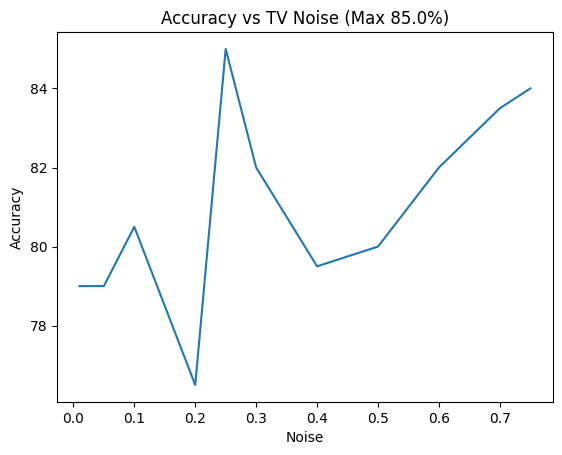

In [ ]:
plt.plot(noises, best_acc_tv)
plt.xlabel('Noise')
plt.ylabel('Accuracy')
plt.title(f'Accuracy vs TV Noise (Max {max(best_acc_tv)}%)')
plt.show()

In [ ]:
noises = [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75]
best_acc_shape = []
def main():
  for n in noises:
    train_dataset = ShapesDataset(num_samples=1000, transform=transform, split='train', noise=(0.1,n,0.1))
    test_dataset = ShapesDataset(num_samples=200, transform=transform, split='test', noise=(0.1,n,0.1))

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    model = VQAModel(num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    best_acc_test = 0
    best_acc = 0
    for epoch in range(5):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion,
                                            optimizer, device)
        test_loss, test_acc = validate(model, test_loader, criterion, device)

        print(f'Epoch {epoch+1}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {test_loss:.4f}, Val Acc: {test_acc:.2f}%')

        if test_acc > best_acc_test:
            best_acc_test = test_acc

        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), 'best_shape_model_by_noise.pth')

    best_acc_shape.append(best_acc_test)


if __name__ == '__main__':
  main()

100%|██████████| 200/200 [00:00<00:00, 3743.51it/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Validating: 100%|██████████| 7/7 [00:01<00:00,  5.33it/s]


Epoch 1:
Train Loss: 0.3811, Train Acc: 86.60%
Val Loss: 0.3724, Val Acc: 89.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.47it/s]


Epoch 2:
Train Loss: 0.3507, Train Acc: 88.60%
Val Loss: 0.3959, Val Acc: 89.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.78it/s]


Epoch 3:
Train Loss: 0.3189, Train Acc: 88.60%
Val Loss: 0.4846, Val Acc: 89.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.66it/s]


Epoch 4:
Train Loss: 0.3109, Train Acc: 88.60%
Val Loss: 0.3987, Val Acc: 89.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.04it/s]


Epoch 5:
Train Loss: 0.2669, Train Acc: 88.60%
Val Loss: 0.5747, Val Acc: 89.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.16it/s]


Epoch 1:
Train Loss: 0.4456, Train Acc: 84.70%
Val Loss: 0.4481, Val Acc: 85.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.91it/s]


Epoch 2:
Train Loss: 0.3908, Train Acc: 87.00%
Val Loss: 0.4313, Val Acc: 85.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.27it/s]


Epoch 3:
Train Loss: 0.3901, Train Acc: 87.00%
Val Loss: 0.5797, Val Acc: 85.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.05it/s]


Epoch 4:
Train Loss: 0.4087, Train Acc: 87.00%
Val Loss: 0.4604, Val Acc: 85.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.15it/s]


Epoch 5:
Train Loss: 0.3710, Train Acc: 87.00%
Val Loss: 0.5099, Val Acc: 85.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.16it/s]


Epoch 1:
Train Loss: 0.5284, Train Acc: 78.90%
Val Loss: 0.5457, Val Acc: 77.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.22it/s]


Epoch 2:
Train Loss: 0.4972, Train Acc: 80.10%
Val Loss: 0.5883, Val Acc: 77.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.21it/s]


Epoch 3:
Train Loss: 0.5016, Train Acc: 80.10%
Val Loss: 0.5715, Val Acc: 77.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.27it/s]


Epoch 4:
Train Loss: 0.4949, Train Acc: 80.10%
Val Loss: 0.5706, Val Acc: 77.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.89it/s]


Epoch 5:
Train Loss: 0.4790, Train Acc: 80.10%
Val Loss: 0.6419, Val Acc: 77.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.05it/s]


Epoch 1:
Train Loss: 0.5967, Train Acc: 71.60%
Val Loss: 0.5196, Val Acc: 79.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.24it/s]


Epoch 2:
Train Loss: 0.5964, Train Acc: 71.80%
Val Loss: 0.5918, Val Acc: 79.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.25it/s]


Epoch 3:
Train Loss: 0.5708, Train Acc: 71.80%
Val Loss: 0.6239, Val Acc: 79.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.69it/s]


Epoch 4:
Train Loss: 0.5779, Train Acc: 71.70%
Val Loss: 0.5917, Val Acc: 80.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.14it/s]


Epoch 5:
Train Loss: 0.5313, Train Acc: 71.10%
Val Loss: 1.1803, Val Acc: 80.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.24it/s]


Epoch 1:
Train Loss: 0.6374, Train Acc: 68.40%
Val Loss: 0.6506, Val Acc: 66.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.08it/s]


Epoch 2:
Train Loss: 0.6208, Train Acc: 69.00%
Val Loss: 0.8381, Val Acc: 66.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.88it/s]


Epoch 3:
Train Loss: 0.6319, Train Acc: 69.00%
Val Loss: 0.6572, Val Acc: 66.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.20it/s]


Epoch 4:
Train Loss: 0.6239, Train Acc: 69.00%
Val Loss: 0.6368, Val Acc: 66.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.05it/s]


Epoch 5:
Train Loss: 0.6042, Train Acc: 69.00%
Val Loss: 0.6797, Val Acc: 66.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.26it/s]


Epoch 1:
Train Loss: 0.6783, Train Acc: 60.40%
Val Loss: 0.6561, Val Acc: 66.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.17it/s]


Epoch 2:
Train Loss: 0.6663, Train Acc: 61.60%
Val Loss: 0.6720, Val Acc: 66.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.28it/s]


Epoch 3:
Train Loss: 0.6652, Train Acc: 61.60%
Val Loss: 0.6551, Val Acc: 66.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.24it/s]


Epoch 4:
Train Loss: 0.6496, Train Acc: 61.50%
Val Loss: 0.6813, Val Acc: 66.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.34it/s]


Epoch 5:
Train Loss: 0.6654, Train Acc: 61.80%
Val Loss: 0.6587, Val Acc: 66.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.16it/s]


Epoch 1:
Train Loss: 0.6978, Train Acc: 54.40%
Val Loss: 0.6961, Val Acc: 53.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.90it/s]


Epoch 2:
Train Loss: 0.6917, Train Acc: 54.50%
Val Loss: 0.6904, Val Acc: 51.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.15it/s]


Epoch 3:
Train Loss: 0.6850, Train Acc: 56.00%
Val Loss: 0.7457, Val Acc: 41.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.25it/s]


Epoch 4:
Train Loss: 0.6757, Train Acc: 55.00%
Val Loss: 0.7281, Val Acc: 52.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.32it/s]


Epoch 5:
Train Loss: 0.6756, Train Acc: 60.80%
Val Loss: 0.6925, Val Acc: 53.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.73it/s]


Epoch 1:
Train Loss: 0.6945, Train Acc: 51.90%
Val Loss: 0.6924, Val Acc: 55.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.27it/s]


Epoch 2:
Train Loss: 0.6915, Train Acc: 54.60%
Val Loss: 0.6983, Val Acc: 56.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.28it/s]


Epoch 3:
Train Loss: 0.6848, Train Acc: 56.60%
Val Loss: 0.7715, Val Acc: 56.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.37it/s]


Epoch 4:
Train Loss: 0.6765, Train Acc: 55.30%
Val Loss: 0.7068, Val Acc: 56.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.15it/s]


Epoch 5:
Train Loss: 0.6814, Train Acc: 56.80%
Val Loss: 0.7372, Val Acc: 53.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.94it/s]


Epoch 1:
Train Loss: 0.6549, Train Acc: 64.30%
Val Loss: 0.6653, Val Acc: 65.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.20it/s]


Epoch 2:
Train Loss: 0.6534, Train Acc: 64.50%
Val Loss: 0.6440, Val Acc: 65.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.23it/s]


Epoch 3:
Train Loss: 0.6519, Train Acc: 64.50%
Val Loss: 0.6628, Val Acc: 65.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.29it/s]


Epoch 4:
Train Loss: 0.6404, Train Acc: 62.80%
Val Loss: 0.6525, Val Acc: 65.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.90it/s]


Epoch 5:
Train Loss: 0.6305, Train Acc: 63.80%
Val Loss: 0.6891, Val Acc: 65.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.26it/s]


Epoch 1:
Train Loss: 0.5881, Train Acc: 74.20%
Val Loss: 0.5571, Val Acc: 75.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.20it/s]


Epoch 2:
Train Loss: 0.5577, Train Acc: 74.50%
Val Loss: 0.5636, Val Acc: 75.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.09it/s]


Epoch 3:
Train Loss: 0.5547, Train Acc: 74.50%
Val Loss: 0.5904, Val Acc: 75.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.94it/s]


Epoch 4:
Train Loss: 0.5587, Train Acc: 74.50%
Val Loss: 0.6735, Val Acc: 75.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.08it/s]


Epoch 5:
Train Loss: 0.5155, Train Acc: 74.50%
Val Loss: 0.6032, Val Acc: 75.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.05it/s]


Epoch 1:
Train Loss: 0.5631, Train Acc: 75.70%
Val Loss: 0.5288, Val Acc: 82.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.18it/s]


Epoch 2:
Train Loss: 0.5396, Train Acc: 77.10%
Val Loss: 0.5033, Val Acc: 82.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.15it/s]


Epoch 3:
Train Loss: 0.5437, Train Acc: 77.10%
Val Loss: 0.5447, Val Acc: 82.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.23it/s]


Epoch 4:
Train Loss: 0.5202, Train Acc: 77.10%
Val Loss: 0.5995, Val Acc: 82.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.21it/s]

Epoch 5:
Train Loss: 0.5036, Train Acc: 77.10%
Val Loss: 0.5297, Val Acc: 82.00%


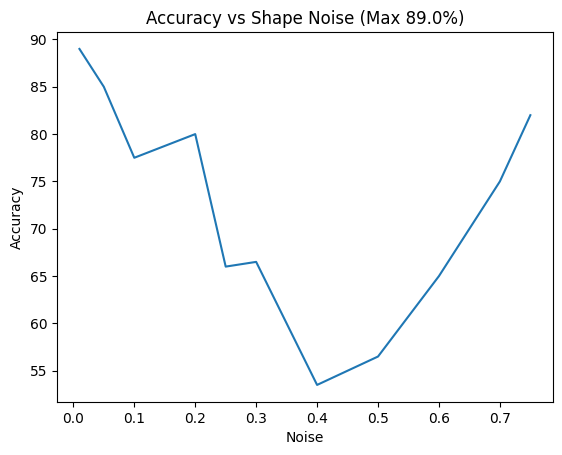

In [ ]:
plt.plot(noises, best_acc_shape)
plt.xlabel('Noise')
plt.ylabel('Accuracy')
plt.title(f'Accuracy vs Shape Noise (Max {max(best_acc_shape)}%)')
plt.show()

In [ ]:
noises = [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75]
best_acc_color = []
def main():
  for n in noises:
    train_dataset = ShapesDataset(num_samples=1000, transform=transform, split='train', noise=(0.1,0.1,n))
    test_dataset = ShapesDataset(num_samples=200, transform=transform, split='test', noise=(0.1,0.1,n))

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    model = VQAModel(num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    best_acc_test = 0
    best_acc = 0
    for epoch in range(5):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion,
                                            optimizer, device)
        test_loss, test_acc = validate(model, test_loader, criterion, device)

        print(f'Epoch {epoch+1}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {test_loss:.4f}, Val Acc: {test_acc:.2f}%')

        if test_acc > best_acc_test:
            best_acc_test = test_acc

        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), 'best_color_model_by_noise.pth')

    best_acc_color.append(best_acc_test)


if __name__ == '__main__':
  main()

Validating: 100%|██████████| 7/7 [00:01<00:00,  6.32it/s]


Epoch 1:
Train Loss: 0.3703, Train Acc: 88.80%
Val Loss: 0.3186, Val Acc: 90.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.88it/s]


Epoch 2:
Train Loss: 0.3191, Train Acc: 90.50%
Val Loss: 0.3117, Val Acc: 90.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.17it/s]


Epoch 3:
Train Loss: 0.2977, Train Acc: 90.50%
Val Loss: 0.3309, Val Acc: 90.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.23it/s]


Epoch 4:
Train Loss: 0.2868, Train Acc: 90.50%
Val Loss: 0.3690, Val Acc: 90.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.23it/s]


Epoch 5:
Train Loss: 0.2904, Train Acc: 90.50%
Val Loss: 0.3775, Val Acc: 90.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.19it/s]


Epoch 1:
Train Loss: 0.4457, Train Acc: 83.30%
Val Loss: 0.4533, Val Acc: 86.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.26it/s]


Epoch 2:
Train Loss: 0.4033, Train Acc: 85.90%
Val Loss: 0.4784, Val Acc: 86.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.01it/s]


Epoch 3:
Train Loss: 0.3934, Train Acc: 85.90%
Val Loss: 0.4768, Val Acc: 86.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.00it/s]


Epoch 4:
Train Loss: 0.3647, Train Acc: 85.90%
Val Loss: 0.5893, Val Acc: 86.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.67it/s]


Epoch 5:
Train Loss: 0.3656, Train Acc: 85.90%
Val Loss: 0.5565, Val Acc: 86.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.25it/s]


Epoch 1:
Train Loss: 0.5212, Train Acc: 81.40%
Val Loss: 0.5599, Val Acc: 75.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.20it/s]


Epoch 2:
Train Loss: 0.4890, Train Acc: 81.40%
Val Loss: 0.5844, Val Acc: 75.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.69it/s]


Epoch 3:
Train Loss: 0.4706, Train Acc: 81.40%
Val Loss: 0.6273, Val Acc: 75.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.84it/s]


Epoch 4:
Train Loss: 0.4741, Train Acc: 81.40%
Val Loss: 0.5996, Val Acc: 75.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.27it/s]


Epoch 5:
Train Loss: 0.4532, Train Acc: 81.40%
Val Loss: 0.6502, Val Acc: 75.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.26it/s]


Epoch 1:
Train Loss: 0.6224, Train Acc: 70.60%
Val Loss: 0.5842, Val Acc: 70.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.06it/s]


Epoch 2:
Train Loss: 0.6101, Train Acc: 71.90%
Val Loss: 0.5897, Val Acc: 70.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.14it/s]


Epoch 3:
Train Loss: 0.5912, Train Acc: 71.90%
Val Loss: 0.5849, Val Acc: 70.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.31it/s]


Epoch 4:
Train Loss: 0.5787, Train Acc: 71.90%
Val Loss: 0.6155, Val Acc: 70.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.26it/s]


Epoch 5:
Train Loss: 0.5715, Train Acc: 71.90%
Val Loss: 0.6239, Val Acc: 70.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.50it/s]


Epoch 1:
Train Loss: 0.6414, Train Acc: 66.90%
Val Loss: 0.5953, Val Acc: 74.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.26it/s]


Epoch 2:
Train Loss: 0.6237, Train Acc: 66.90%
Val Loss: 0.7001, Val Acc: 74.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.18it/s]


Epoch 3:
Train Loss: 0.6356, Train Acc: 66.80%
Val Loss: 0.6571, Val Acc: 60.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.24it/s]


Epoch 4:
Train Loss: 0.6269, Train Acc: 66.30%
Val Loss: 0.6016, Val Acc: 74.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.17it/s]


Epoch 5:
Train Loss: 0.6112, Train Acc: 67.60%
Val Loss: 0.6163, Val Acc: 71.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.09it/s]


Epoch 1:
Train Loss: 0.6675, Train Acc: 63.10%
Val Loss: 0.6375, Val Acc: 70.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.09it/s]


Epoch 2:
Train Loss: 0.6535, Train Acc: 63.20%
Val Loss: 0.6565, Val Acc: 70.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.09it/s]


Epoch 3:
Train Loss: 0.6471, Train Acc: 63.10%
Val Loss: 0.6901, Val Acc: 70.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.06it/s]


Epoch 4:
Train Loss: 0.6516, Train Acc: 61.00%
Val Loss: 0.6557, Val Acc: 70.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.93it/s]


Epoch 5:
Train Loss: 0.6363, Train Acc: 62.50%
Val Loss: 0.6484, Val Acc: 70.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.05it/s]


Epoch 1:
Train Loss: 0.6990, Train Acc: 50.90%
Val Loss: 0.6986, Val Acc: 44.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.17it/s]


Epoch 2:
Train Loss: 0.6817, Train Acc: 56.90%
Val Loss: 0.6905, Val Acc: 56.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.94it/s]


Epoch 3:
Train Loss: 0.6883, Train Acc: 55.80%
Val Loss: 0.7693, Val Acc: 52.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.21it/s]


Epoch 4:
Train Loss: 0.6887, Train Acc: 54.60%
Val Loss: 0.6807, Val Acc: 58.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.18it/s]


Epoch 5:
Train Loss: 0.6818, Train Acc: 56.50%
Val Loss: 0.6572, Val Acc: 61.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.11it/s]


Epoch 1:
Train Loss: 0.6942, Train Acc: 54.80%
Val Loss: 0.7001, Val Acc: 44.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.18it/s]


Epoch 2:
Train Loss: 0.6901, Train Acc: 52.60%
Val Loss: 0.6994, Val Acc: 50.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.23it/s]


Epoch 3:
Train Loss: 0.6843, Train Acc: 53.70%
Val Loss: 0.7871, Val Acc: 47.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.14it/s]


Epoch 4:
Train Loss: 0.6783, Train Acc: 56.30%
Val Loss: 0.7198, Val Acc: 48.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.28it/s]


Epoch 5:
Train Loss: 0.6713, Train Acc: 57.30%
Val Loss: 0.7447, Val Acc: 47.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.35it/s]


Epoch 1:
Train Loss: 0.6478, Train Acc: 67.10%
Val Loss: 0.6929, Val Acc: 62.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.22it/s]


Epoch 2:
Train Loss: 0.6265, Train Acc: 67.10%
Val Loss: 0.6967, Val Acc: 62.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.29it/s]


Epoch 3:
Train Loss: 0.6265, Train Acc: 67.10%
Val Loss: 0.6913, Val Acc: 62.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.67it/s]


Epoch 4:
Train Loss: 0.6263, Train Acc: 67.10%
Val Loss: 0.6724, Val Acc: 62.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.59it/s]


Epoch 5:
Train Loss: 0.5956, Train Acc: 67.10%
Val Loss: 0.7212, Val Acc: 62.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.14it/s]


Epoch 1:
Train Loss: 0.6136, Train Acc: 72.30%
Val Loss: 0.5602, Val Acc: 73.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.33it/s]


Epoch 2:
Train Loss: 0.5915, Train Acc: 72.90%
Val Loss: 0.5929, Val Acc: 73.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.49it/s]


Epoch 3:
Train Loss: 0.5903, Train Acc: 72.90%
Val Loss: 0.5923, Val Acc: 73.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.57it/s]


Epoch 4:
Train Loss: 0.5703, Train Acc: 72.90%
Val Loss: 0.5686, Val Acc: 73.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.30it/s]


Epoch 5:
Train Loss: 0.5667, Train Acc: 72.90%
Val Loss: 0.6295, Val Acc: 73.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.16it/s]


Epoch 1:
Train Loss: 0.5853, Train Acc: 74.40%
Val Loss: 0.6157, Val Acc: 73.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.09it/s]


Epoch 2:
Train Loss: 0.5653, Train Acc: 75.00%
Val Loss: 0.6248, Val Acc: 73.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.98it/s]


Epoch 3:
Train Loss: 0.5584, Train Acc: 75.00%
Val Loss: 0.6188, Val Acc: 73.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.31it/s]


Epoch 4:
Train Loss: 0.5575, Train Acc: 75.00%
Val Loss: 0.6736, Val Acc: 73.00%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.17it/s]

Epoch 5:
Train Loss: 0.5450, Train Acc: 75.00%
Val Loss: 0.6594, Val Acc: 73.00%


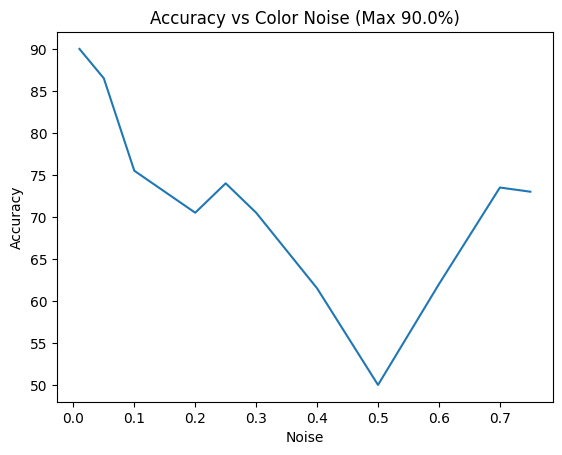

In [ ]:
plt.plot(noises, best_acc_color)
plt.xlabel('Noise')
plt.ylabel('Accuracy')
plt.title(f'Accuracy vs Color Noise (Max {max(best_acc_color)}%)')
plt.show()

In [ ]:
best_acc_overall = []
def main():
    train_dataset = ShapesDataset(num_samples=1000, transform=transform, split='train', noise=(0.25,0.01,0.01))
    test_dataset = ShapesDataset(num_samples=200, transform=transform, split='test', noise=(0.25, 0.01, 0.01))

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    model = VQAModel(num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    best_acc = 0
    for epoch in range(10):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion,
                                            optimizer, device)
        test_loss, test_acc = validate(model, test_loader, criterion, device)

        print(f'Epoch {epoch+1}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), 'best_overall.pth')

        best_acc_overall.append(test_acc)


if __name__ == '__main__':
  main()

100%|██████████| 200/200 [00:00<00:00, 1845.62it/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Validating: 100%|██████████| 7/7 [00:01<00:00,  6.14it/s]


Epoch 1:
Train Loss: 0.1628, Train Acc: 95.80%
Val Loss: 0.1827, Test Acc: 96.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.16it/s]


Epoch 2:
Train Loss: 0.0871, Train Acc: 98.40%
Val Loss: 0.2345, Test Acc: 96.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.11it/s]


Epoch 3:
Train Loss: 0.0623, Train Acc: 98.40%
Val Loss: 0.2618, Test Acc: 96.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.24it/s]


Epoch 4:
Train Loss: 0.0475, Train Acc: 98.40%
Val Loss: 0.3935, Test Acc: 96.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  5.07it/s]


Epoch 5:
Train Loss: 0.0532, Train Acc: 98.50%
Val Loss: 0.3077, Test Acc: 96.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.18it/s]


Epoch 6:
Train Loss: 0.0468, Train Acc: 98.80%
Val Loss: 0.3977, Test Acc: 96.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.25it/s]


Epoch 7:
Train Loss: 0.0510, Train Acc: 98.80%
Val Loss: 0.3094, Test Acc: 96.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.22it/s]


Epoch 8:
Train Loss: 0.0423, Train Acc: 98.80%
Val Loss: 0.4615, Test Acc: 96.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  6.23it/s]


Epoch 9:
Train Loss: 0.0448, Train Acc: 98.70%
Val Loss: 0.3959, Test Acc: 96.50%


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.82it/s]

Epoch 10:
Train Loss: 0.0212, Train Acc: 99.40%
Val Loss: 0.6697, Test Acc: 95.50%


In [ ]:
print(max(best_acc_overall))

96.5


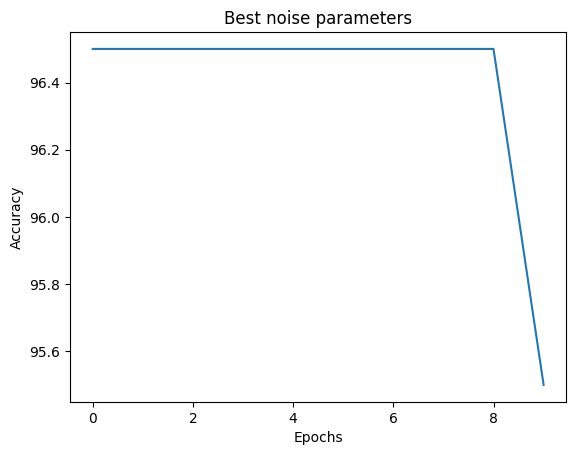

In [ ]:
plt.plot(best_acc_overall)
plt.title("Best noise parameters")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()